# Part 1

## Question 1

## Python Implementation 

In [39]:
#importing necessary libraries
from itertools import product
from math import sqrt

import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

from scipy.integrate import odeint


### Import data

In [40]:
states = pd.read_csv("us-states.csv")


In [41]:
texas_index = states["state"] == 'Texas'
texas = states[texas_index]
texas

,date,state,fips,cases,deaths
98,2020-02-12,Texas,48,1,0
105,2020-02-13,Texas,48,2,0
112,2020-02-14,Texas,48,2,0
119,2020-02-15,Texas,48,2,0
126,2020-02-16,Texas,48,2,0
...,...,...,...,...,...
42389,2022-04-08,Texas,48,6701901,87747
42445,2022-04-09,Texas,48,6704457,87796
42501,2022-04-10,Texas,48,6705329,87796
42557,2022-04-11,Texas,48,6707045,87801


Text(0, 0.5, 'Case Count')

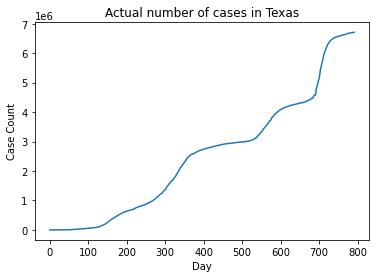

In [42]:
#time period = days
t = np.linspace(0, 791, 791)
plt.plot(t, texas["cases"])
plt.title("Actual number of cases in Texas")
plt.xlabel("Day")
plt.ylabel("Case Count")

C:\Users\abisi\AppData\Local\Temp/ipykernel_14424/985439890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas["infected"] = texas["cases"] - x


Text(0, 0.5, 'Fraction of Population')

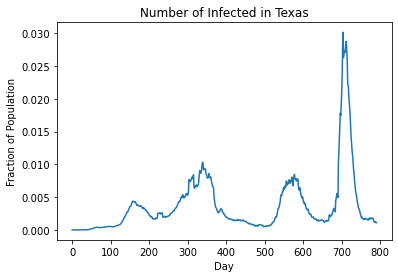

In [43]:
x = list(texas["cases"])
for i in range(0,13):
    x.insert(0,0)
x = x[:-13]
texas["infected"] = texas["cases"] - x
plt.plot(t, texas["infected"]/N)
plt.title("Number of Infected in Texas")
plt.xlabel("Day")
plt.ylabel("Fraction of Population")

## Question 2

### Parameters

In [44]:
#time period = days
t = np.linspace(0, 791, 791)

#I[t] is the number of cases per day/true outcome
I =  []
for count in texas["cases"]:
    I.append(count)
    
#N: total population - taken from https://www.census.gov/quickfacts/TX
N = 29527941

In [45]:
#parts of code taken from SIR.Extensions.ipynb from Canvas

#number of infected people and recovered people initially
#using same values as code. Assuming not very many people were infected in Texas, since outbreak started in Washington state
I0 = 1

#formula for estimating R0 taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7751056/
        #  R0 = I[t] * SI / t , were SI is the time between the first and second COVID case
        #second covid case data from 
R0 = 0

#number  of people who are initially susceptible
S0 = N - I0 - R0 

# Initial vector
y0 = S0, I0, R0

# average recovery time is 2 weeks 
gamma = 1/14

### Model Engine

In [46]:
#code taken from SIR.Extensions.ipynb from Canvas
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [47]:
#code below taken from SIR.Extensions.ipynb from Canvas
#x0 = major outbreak occurs (state of emergency) = March 12

#data looked at: https://www.worldometers.info/coronavirus/usa/texas/
e = [0,150,200,250,340,370,400,500,557,580,610,640,660,700,708]
R0 = [2.99,1,0.59,1.5,1.0,0.3,.88,1.9,1.22,1,.5,1.04,1.04,3.8,.7,0.4]
x0 = [100,200,210,300,580,700,700,705,705,705,705,705,705,705,705]

k=.01
def dyn_R_0(time):
    z = 0
    for i in range(len(e)):
        if time > e[i]:
            R_start = R0[i]
            R_end =  R0[i+1]
            x = x0[i]
            z = logistic_R_0(time, R_start, R_end, x)
    return z

def logistic_R_0(time, R_start, R_end, x0):
    return (R_start-R_end) / (1 + np.exp(-k*(-time+x0))) + R_end

def logistic_beta(time):
    R0_list.append((time,dyn_R_0(time)))
    return dyn_R_0(time) * gamma

In [48]:
#code taken from SIR.Extensions.ipynb from Canvas
R0_list = []
ret = odeint(deriv_dynamic, y0, t,args=(N, logistic_beta, gamma))
S, I, R = ret.T


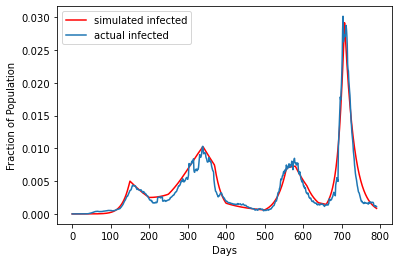

In [49]:
plt.figure(facecolor = 'w')
plt.plot(t, I/N, 'r', label = "simulated infected")
plt.plot(t, texas["infected"]/N, label = "actual infected")

plt.xlabel("Days")
plt.ylabel("Fraction of Population")

plt.legend()


## Question 3 

### root mean square error

In [17]:
def root_mean_square_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + (dif**2)
    return sqrt(total/N)
     

In [18]:
actual_I = list(texas["infected"])
simulated_I = I 

In [19]:
print("The root mean square error is:", round(root_mean_square_error(actual_I, simulated_I),1))

The root mean square error is: 31744.8


### mean absolute error

In [20]:
def mean_absolute_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + abs(dif)
    return total/N

In [21]:
print("The mean absolute error is:", round(mean_absolute_error(actual_I, simulated_I)),2)

The mean absolute error is: 20210 2


# Part 2

## Plotting changes in R0

In [22]:
#cite: data from https://www.healthdata.org/covid/data-downloads

#import data
data_2020 = pd.read_csv("data_download_file_reference_2020.csv")
data_2021 = pd.read_csv("data_download_file_reference_2021.csv")
data_2022 = pd.read_csv("data_download_file_reference_2022.csv")

In [23]:
#get data for only texas
texas_2020_index = data_2020["location_name"] == "Texas"
texas_2021_index = data_2021["location_name"] == "Texas"
texas_2022_index = data_2022["location_name"] == "Texas" 

texas_2020 = data_2020[texas_2020_index]
#adjusting so dates match previous dataset
texas_2020 = texas_2020.iloc[8:]
texas_2021 = data_2021[texas_2021_index]
texas_2022 = data_2022[texas_2022_index]
#adjusting so dates match previous dataset
texas_2022 = texas_2022.iloc[0:102]

In [24]:
mobility = []
x = list(texas_2020["mobility_mean"])
y = list(texas_2021["mobility_mean"])
z = list(texas_2022["mobility_mean"])

for i in range(len(texas_2020)):
    mobility.append(x[i])
    
for i in range(len(texas_2021)):
    mobility.append(y[i])
    
for i in range(len(texas_2022)):
    mobility.append(z[i])

In [25]:
mask_use = []

x = list(texas_2020["mask_use_mean"])
y = list(texas_2021["mask_use_mean"])
z = list(texas_2022["mask_use_mean"])

for i in range(len(texas_2020)):
    mask_use.append(x[i])
    
for i in range(len(texas_2021)):
    mask_use.append(y[i])
    
for i in range(len(texas_2022)):
    mask_use.append(z[i])

In [26]:
testing = []

x = list(texas_2020["testing_mean"])
y = list(texas_2021["testing_mean"])
z = list(texas_2022["testing_mean"])

for i in range(len(texas_2020)):
    testing.append(x[i])
    
for i in range(len(texas_2021)):
    testing.append(y[i])
    
for i in range(len(texas_2022)):
    testing.append(z[i])

In [27]:
vacc = []

x = list(texas_2020["cumulative_all_effectively_vaccinated"])
y = list(texas_2021["cumulative_all_effectively_vaccinated"])
z = list(texas_2022["cumulative_all_effectively_vaccinated"])

for i in range(len(texas_2020)):
    vacc.append(x[i])
    
for i in range(len(texas_2021)):
    vacc.append(y[i])
    
for i in range(len(texas_2022)):
    vacc.append(z[i])

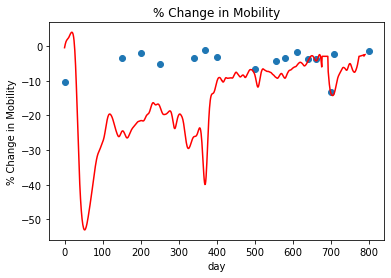

In [96]:
t = range(0,791)
plt.plot(t, mobility, 'r', label = "mobility")
plt.title("% Change in Mobility")
plt.xlabel("day")
plt.ylabel("% Change in Mobility")


e = [0,150,200,250,340,370,400,500,557,580,610,640,660,700,708,800]
R0 = [2.99,1,0.59,1.5,1.0,0.3,.88,1.9,1.22,1,.5,1.04,1.04,3.8,.7,0.4]

x_datapoints = e
y_datapoints = [-3.5 * r for r in R0]

plt.scatter(x_datapoints,y_datapoints, label = "R0 values")

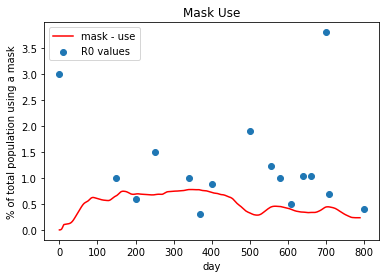

In [100]:
t = range(0,791)
plt.plot(t, mask_use, 'r', label = "mask - use")
plt.title("Mask Use")
plt.xlabel("day")
plt.ylabel("% of total population using a mask")


x_datapoints = e
y_datapoints = [1 * r for r in R0]


plt.scatter(x_datapoints,y_datapoints, label = "R0 values")
plt.legend()

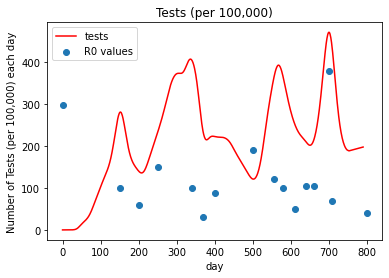

In [102]:
t = range(0,791)
plt.plot(t, testing, 'r', label = "tests")
plt.title("Tests (per 100,000)")
plt.xlabel("day")
plt.ylabel("Number of Tests (per 100,000) each day")


x_datapoints = e
y_datapoints = [100 * r for r in R0]


plt.scatter(x_datapoints,y_datapoints, label = "R0 values")
plt.legend()

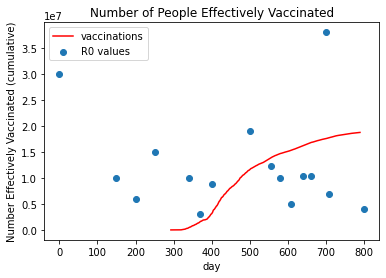

In [110]:
t = range(0,791)
plt.plot(t, vacc, 'r', label = "vaccinations")
plt.title("Number of People Effectively Vaccinated")
plt.xlabel("day")
plt.ylabel("Number Effectively Vaccinated (cumulative)")


x_datapoints = e
y_datapoints = [(10**7) * r for r in R0]

plt.scatter(x_datapoints,y_datapoints, label = "R0 values")
plt.legend()